In [39]:
%matplotlib inline

import photutils, astropy, math
from photutils import datasets
from astropy.modeling.functional_models import Sersic2D

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from astropy import visualization, convolution, stats

from collections import OrderedDict

import time

import ashd

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import subprocess

import skimage
from skimage import morphology, filters

from scipy import ndimage

import sep

from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy import interpolate, signal

#import mpld3
#mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [16, 16]

In [2]:
def ds9me(val): subprocess.Popen(["/usr/bin/ds9", val])

norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

def plotme(obj, rng=[10, 99]):
    vmin, vmax = np.percentile(obj, rng)
    plt.imshow(obj, cmap="Greys_r", norm=norm, vmin=vmin, vmax=vmax)

In [3]:
def cut_corners(objlist, thresh=30, size=[2048, 2048]):
    for i in objlist:
        x = i['x']; y = i['y']
        if not (x < thresh and y < thresh) and not (x > (size[0] - thresh) and y < thresh):
            if not (x < thresh and y > (size[1] - thresh)) and not (x > (size[0] - thresh) and y > (size[1] - thresh)):
                yield i
    

In [4]:
butler = ashd.Butler(data_dir="/run/media/me/DATA/asas-sn-images")

In [5]:
coord = SkyCoord("02h39m59.3s −34d26m57s")
imgn = butler.get_image_fn(ra=coord.ra.deg,dec=coord.dec.deg)
#ds9me(imgn)

In [6]:
img = fits.open(imgn)
data = img[0].data
vmin, vmax = np.percentile(data, [60, 95])
#data[~(data > vmin)] = 0
#plt.imshow(data, cmap="Greys_r", norm=norm, vmin=vmin, vmax=vmax)

In [7]:
NBINS = 1000
print(f'Max: {np.max(data)}')

Max: 533175.0


In [8]:
limg = np.arcsinh(data)
limg[~(limg > 6.9)] = 0
lm = morphology.local_maxima(limg)
#plt.imshow(lm, cmap="Greys_r")

/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/skimage/morphology/extrema.py:239: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[sl] = value
/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/skimage/morphology/extrema.py:242: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[sl] = value


In [9]:
yeet = np.sort(data.flatten())
np.amax(yeet)
np.percentile(yeet, [10,99])


array([478.48355103, 959.22449097])

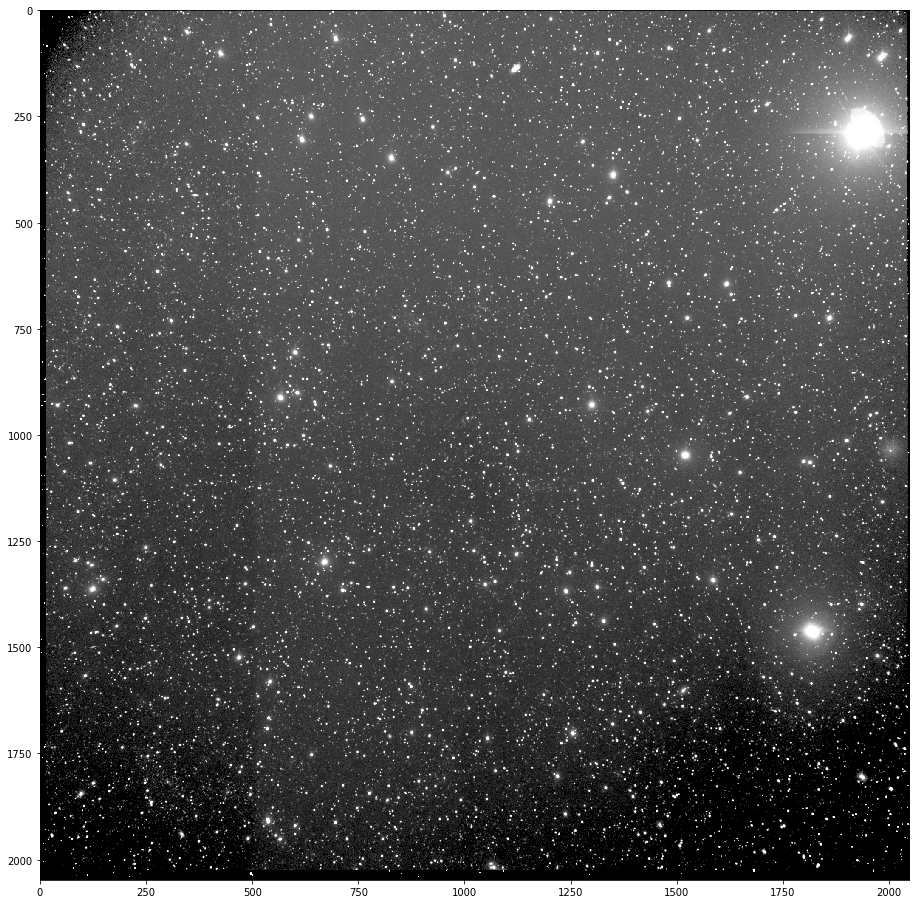

In [46]:
imgn2 = butler.get_image_fn(ra=168.37, dec=22.151)
img2 = fits.open(imgn2)
data2 = img2[0].data
plotme(data2)

In [11]:
limg = np.arcsinh(data2)
limg[~(limg > 6.7)] = 0
lm = morphology.local_maxima(limg)
#plt.imshow(lm, cmap="Greys_r")

In [47]:
data3 = data2.byteswap().newbyteorder()
background = sep.Background(data3)

In [50]:
data_sub = data3 - background
objects = sep.extract(data_sub, 1.5, err=background.globalrms)

20.26548277620841; 

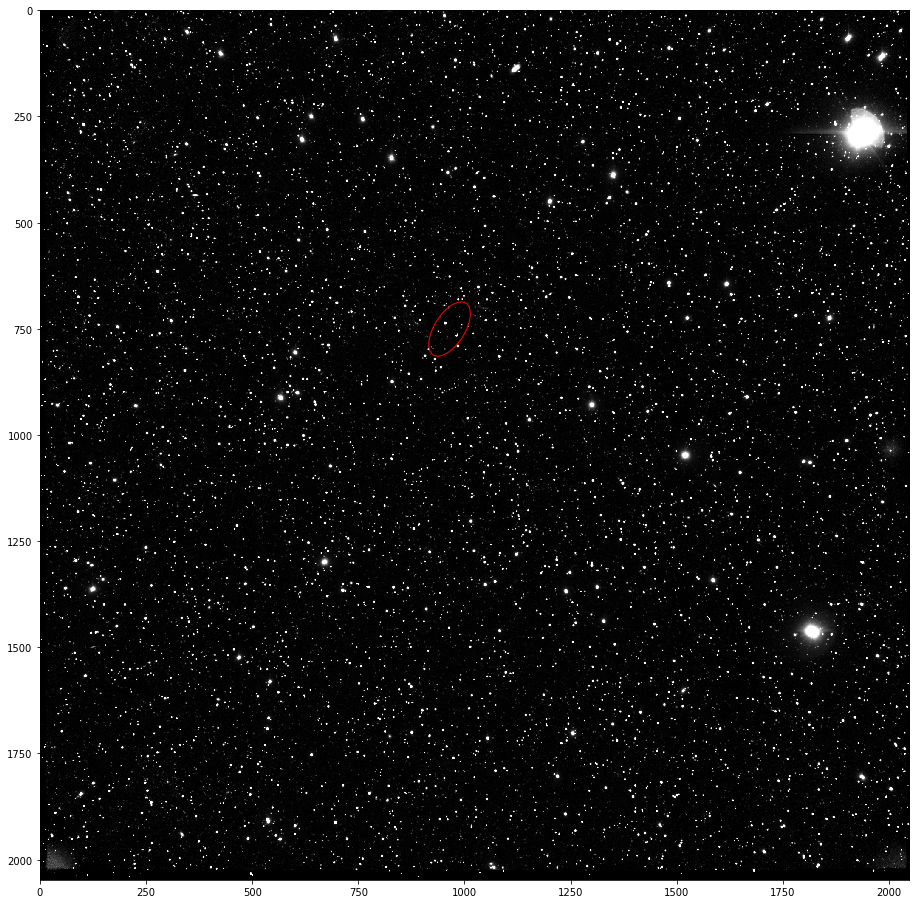

In [51]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(data_sub, [10,99])
im = ax.imshow(data_sub, interpolation='nearest', origin='upper', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

#largest = sorted(objects, key=lambda x: x['npix'], reverse=True)[0:11]

avgsb = np.mean(objects['cflux'] / objects['npix'])

# plot an ellipse for each object
for obj in cut_corners(largest, thresh=200):
    sb = obj['cflux'] / obj['npix']
    print(sb, end="; ")
    if sb > avgsb:
        print("skipped!")
        continue
    e = patches.Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],
                height=6*obj['b'],
                angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


In [15]:
sorted(objects, key=lambda x: x['npix'], reverse=True)[0:3]

[(3.51021242, 25707, 23375, 734, 1066, 651, 986, 856.70817625, 814.5179527, 2988.33537425, 4687.90401196, -2046.8149852, 0.0017642, 0.00242042, -0.00120137, 77.80957031, 40.2729454, -0.98215747, 0.0004774, 0.00030432, 0.00041688, 556917.9375, 563353.25, 1842.24243164, 3552.00708008, 833, 934, 833, 934, 1),
 (3.51021242, 16609, 15727, 0, 246, 1840, 2046, 16.3990371, 1992.16460469, 789.70523445, 2682.98109185, -385.91255145, 6.24269468e-05, 7.84927127e-05, -4.00267535e-05, 52.52257538, 26.72200203, -1.37724733, 0.00136203, 0.0004009, 0.00039182, 2476583.75, 2513310.5, 1541.68322754, 2569.45361328, 28, 1852, 28, 1852, 3),
 (3.51021242, 15829, 14391, 55, 313, 1893, 2045, 107.53515012, 2029.38327336, 3874.88633618, 1141.03416191, -1137.38795688, 0.00145682, 0.00043346, -0.00053485, 65.46907806, 27.01333046, -0.34699824, 0.00036481, 0.00123888, 0.00072729, 725742.1875, 730790.625, 2217.33154297, 4013.39794922, 135, 1983, 135, 1983, 1)]

In [16]:
data2b = data2.byteswap().newbyteorder()
background2 = sep.Background(data2b)
d2sub = data2b - background2
objects2 = sep.extract(d2sub, 1.5, err=background2.globalrms)

2495.4700077521; skipped!
910.6180030812119; skipped!
788.1830073995771; skipped!
29.404928705601094; skipped!
12.698509348024569; 610.9501602564103; skipped!
55.869403788204906; skipped!
550.8241011235955; skipped!


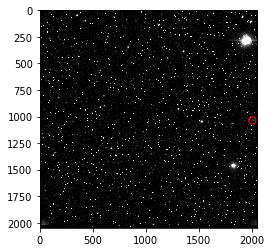

In [17]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(d2sub, [10,99])
im = ax.imshow(d2sub, interpolation='nearest', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

#objects2['thresh'].mean()
avgsb = np.mean(objects2['cflux'] / objects2['npix'])


largest = sorted(objects2, key=lambda x: x['npix'], reverse=True)[0:11]

# plot an ellipse for each object
for obj in cut_corners(largest, thresh=200):
    sb = obj['cflux'] / obj['npix']
    print(sb, end="; ")
    if sb > avgsb:
        print("skipped!")
        continue
    e = patches.Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],
                height=6*obj['b'],
                angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [18]:
np.mean(objects2['cflux'] / objects2['npix'])

27.77303127251153

In [58]:
combos = [(11.4158333333, 38.0411111111), (8.89083333333, 36.4977777778), (5.07208333333, 59.3038888889), (6.54583333333, -11.0444444444)]

img3n = butler.get_image_fn(*combos[1])
#img3n = butler.get_image_fn(ra=168.37, dec=22.151)
img3 = fits.open(img3n)
data3 = img3[0].data

In [59]:
data3b = data3.byteswap().newbyteorder()
background3 = sep.Background(data3b)
d3sub = data3b - background3
objects3 = sep.extract(d3sub, 1.5, err=background3.globalrms)

11


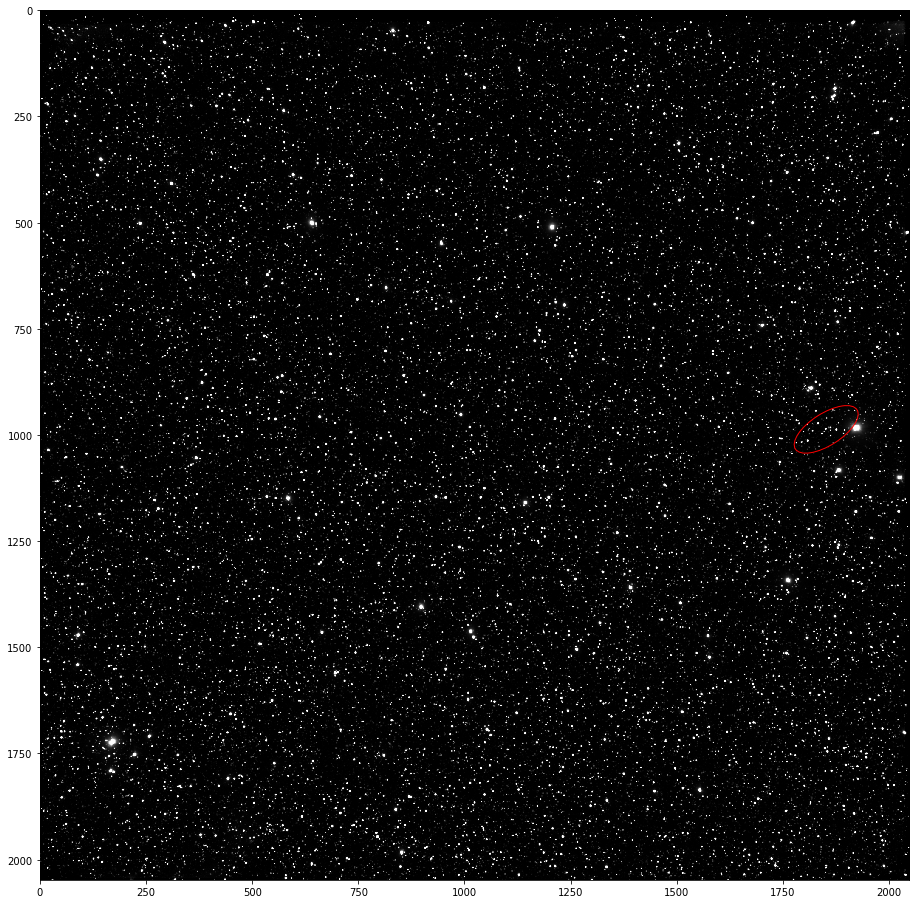

In [60]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(d3sub, [10,99])
im = ax.imshow(d3sub, interpolation='nearest', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

#objects2['thresh'].mean()

objects3 = np.array(list(cut_corners(objects3, thresh=225)))

avgsb = np.mean(np.power(objects3['cflux'], 1) / objects3['npix'])
brightsort = sorted(objects3, key=lambda x: x['cflux'] / x['npix'])[0:objects3.size*9//10]
#ellipticest = sorted(brightsort, key=lambda x: x['a']/x['b'])[0:len(brightsort)*9//10] #A bad idea in hindsight
ellipticsort = list(filter(lambda x: x['b'] / x['a'] > 0.1, brightsort))
largest = sorted(ellipticsort, key=lambda x: x['npix'], reverse=True)[0:11]
#largest = sorted(objects2, key=lambda x: x['npix'], reverse=True)[0:11]
print(len(largest))

largest = largest[1:2]

# plot an ellipse for each object
for obj in largest:
    sb = obj['cflux']**(1) / obj['npix']
    #print(sb, end="; ")
    #print(int(obj['y']))
    #if sb > avgsb:
        #print("skipped!")
        #continue
    #else:
    e = patches.Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],
                height=6*obj['b'],
                angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    dab = obj
        #break
    
    #n = patches.Rectangle(xy=(obj['x'], obj['y']), width=2, height=2, color='green')
    #ax.add_artist(n)
    
    #n2 = patches.Rectangle(xy=(obj['x2'], obj['y2']), width=2, height=2, color='cornflowerblue')
    #ax.add_artist(n2)
        #break

In [22]:
ds9me(img3n)

Step 2: Utilize the raw blobs `sep` gives us; stars should have a sharp curve, while galaxies go up slightly, have small inconsistencies, then go down. Not sure what to do with the random circles source extractor is spitting out, though.

In [23]:
img3n

'/run/media/me/DATA/asas-sn-images/F0025-10_1599.bc.fits'

In [42]:
def is_galaxy(obj, data, default=[30, 2030], extend=30, sigma=1000):
    subset, smoothed = datasets(obj, data, default, extend, sigma)
    
    maxval = np.mean(smoothed) + np.std(smoothed)
    mid = smoothed[smoothed.size // 2]
    return mid > maxval

    #for i in range(subset.size):
    #    if subset[i] > smoothed[i]: pass
    #        #subset[i] = smoothed[i]
    #return (subset, smoothed)

def datasets(obj, data, default, extend, sigma):
    xmin = int(obj['xmin']) - extend
    xmin = xmin if xmin > default[0] else default[0]
    xmax = int(obj['xmax']) + extend
    xmax = xmax if xmax < default[1] else default[1]
    
    subset = data[int(obj['y']), xmin:xmax]
    #ash = np.arcsinh(subset)
    smoothed = signal.cspline1d(subset, sigma)
    
    return (subset, smoothed)
    

#ash = np.arcsinh(data2[1025, 30:2030])
#print(ash)
#plt.plot(ash)
#kern = kernels.DotProduct() + kernels.WhiteKernel()
#fitted = GaussianProcessRegressor(kern).fit(np.atleast_2d(ash).T, np.atleast_2d(np.full_like(ash, np.mean(ash))).T)
#ash, smoothed = is_galaxy(largest[2], data)
#print(smoothed.size)
#plt.plot(ash, marker='o', markersize=2, linestyle='')
#plt.plot(xf, yf, '-')
#plt.plot(delete_stars(ash), color='red', marker='o', linestyle='', markersize=1)
#plt.plot(smoothed, '-')
print(is_galaxy(largest[0], data))
#plt.plot(fitted.predict(np.atleast_2d(ash))[0]);

True


In [25]:
def normalize(x, times = 1):
    maxv = np.mean(x) + np.std(x)
    out = [(x[i-1]+x[i+1])/2 if x[i] > maxv else x[i] for i in range(1, len(x) - 1)]
    if times > 1:
        return normalize(out, times - 1)
    return out

def delete_stars(x):
    d = np.diff(x)
    maxd = np.mean(d) + np.std(d)
    out = np.copy(x)
    
    for i in range(1, out.size):
        if (out[i] - out[i-1])> maxd:
            out[i] = out[i-1]
    return out

def p_trans(x, p=2):
    out = np.zeros_like(x)
    for i in range(out.size):
        c = 0
        for j in range(x.size):
            if i == j: continue
            #print((j - i)^2+1,end=" ")
            c += x[i]/((j-i)**p+1)
        out[i] = c
    return out

#plt.plot(delete_stars(ash))
#plt.plot(p_trans(ash, 4))

In [26]:
np.atleast_2d(ash).T

array([[490.63873],
       [490.96606],
       [492.40524],
       [490.8937 ],
       [491.93848],
       [491.734  ],
       [493.1324 ],
       [495.43396],
       [493.56403],
       [493.97626],
       [491.14307],
       [489.04007],
       [492.1607 ],
       [489.9134 ],
       [487.92297],
       [489.51263],
       [491.02798],
       [497.0073 ],
       [499.20108],
       [492.62088],
       [488.4583 ],
       [489.0106 ],
       [491.42737],
       [490.636  ],
       [491.05844],
       [490.84833],
       [491.54462],
       [489.7703 ],
       [489.42587],
       [491.88507],
       [490.84164],
       [488.03867],
       [491.9248 ],
       [491.9862 ],
       [492.1635 ],
       [491.271  ],
       [493.73816],
       [496.11658],
       [496.89505],
       [495.56763],
       [495.35382],
       [495.987  ],
       [495.55582],
       [496.41733],
       [499.7741 ],
       [498.5695 ],
       [497.0926 ],
       [494.49298],
       [496.05066],
       [494.14624],


In [27]:
print(np.mean(ash) + np.std(ash))
db = data.byteswap().newbyteorder()

514.23096


In [28]:
bkg = sep.Background(db)

In [29]:
dbsub = db - bkg
boxed = ndimage.generic_filter(dbsub, np.nanmean, footprint=mask)

NameError: name 'mask' is not defined

In [ ]:
plotme(boxed)

In [ ]:
objects3 = sep.extract(boxed, 1.5)
objects3.size

In [ ]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(d3sub, [10,99])
im = ax.imshow(np.arcsinh(boxed), interpolation='nearest', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

#objects2['thresh'].mean()

objects3 = np.array(list(cut_corners(objects3, thresh=225)))

avgsb = np.mean(np.power(objects3['cflux'], 1) / objects3['npix'])
brightsort = sorted(objects3, key=lambda x: x['cflux'] / x['npix'])[0:objects3.size*9//10]
#ellipticest = sorted(brightsort, key=lambda x: x['a']/x['b'])[0:len(brightsort)*9//10] #A bad idea in hindsight
ellipticsort = list(filter(lambda x: x['b'] / x['a'] > 0.1, brightsort))
largest = sorted(ellipticsort, key=lambda x: x['npix'], reverse=True)[0:11]
#largest = sorted(objects2, key=lambda x: x['npix'], reverse=True)[0:11]
print(len(largest))

# plot an ellipse for each object
for obj in largest:
    e = patches.Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],
                height=6*obj['b'],
                angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
    #n = patches.Rectangle(xy=(obj['x'], obj['y']), width=2, height=2, color='green')
    #ax.add_artist(n)
    
    #n2 = patches.Rectangle(xy=(obj['x2'], obj['y2']), width=2, height=2, color='cornflowerblue')
    #ax.add_artist(n2)
        #break

In [61]:
import scanner

In [ ]:
scanner.